# Evaluate the models

In this notebook we run identical cells for each model we have tested. There is a lot of output over this notebook. The reader is invited to either re-produce results or move straight to the 3_Compare_models notebook to see a summary of results.

Models are shown below. Some of the hyper parameters are listed to give the reader a quick view of what was changing.

All models had training and validation data sampled randomly form the MS Coco train2017 file (which contain ~128k images). The test data was sampled from the MS Coco val2017 file. 

* Models named `random`, just sampled images and associated captions randomly from the data.
* Models named `sports` reduced the scope of data to only pictures including objects within the sports super-category in MS Coco. This reduced the size of the train2017 data from ~128k to ~23k images. Our hypothesis was that it would be easier to train a model with a more specific range of images vs a wide range of images.
* `everything` model was trained on the entire dataset. After splitting into train and val, this gave ~102k training and ~15k validation images.
* `sports_encoder` model used a different encoder. With one fully connected layer at the end rather than 2. This architecture is the more standard way of approaching and encoder/decoder model. We set hyper parameters equal to our best performing model: sports_v2. We are including results, but it is not posssible to recreate them using our code without manually changing some lines in the model.py file. `sports_encoder` was actually the best performing model.
* To see if a larger vocab helped the model to deal with unseen images better, the vocab for `sports_v5` was build from all the captions in the entire train2017 data set. 

The table includes some additional columns which should be explained:

* `captions_name`. This sets the name of the vocab and captions json files which are saved for each model. For example, `random_v1` has its captions files saved as `Datasets/coco/annotations/random_v1_train.json`, `Datasets/coco/annotations/random_v1_val.json`, and `Datasets/coco/annotations/random_v1_test.json`. The vocab file is saved as `vocabulary/random_v1word2idx.json`.
* `checkpoint folder`. These is the folder where model checkpoints and other meta data are saved. So `random_v1` model has checkpoints saved in `model/model_v1`. 
* Finally we show the notebook file name where the training was done to ease navigation through our folder.


| Model      | LSTM layers | embedding size | batch_size | freq_threshold | train_size.   |captions_name | checkpoint folder| training_notebook |
| -----------|:--------:   | :------------: | :--------: | :-----------:  | :------------:|------------- | ---------------- | ----------------- |
| random_v1  | 1           | 512            | 32         | 5              | 10k           | random_v1    | model_v1         | train_random_v1   |
| random_v2  | 3           | 1024           | 128        | 5              | 10k           | random_v2    | model_v2         | train_random_v2   |
| sports_v1  | 3           | 1024           | 128        | 5              | 10k           | sports_v1    | model_sports_v1  | train_sports      |
| sports_v2  | 3           | 512            | 128        | 4              | 15k           | sports_v2    | model_sports_v3  | train_sports2     |
| **Other Models** |       |                |            |                |               |              |                  |                   |
| sports_v4  | 3           | 512            | 64         | 5              | 15k           | sports_v4    | model_sports_v4  | train_sports2     |
| sports_v5  | 3           | 1024           | 64         | 5              | 20k           | sports_v5    | model_sports_v5  | train_sports      | 
| everything | 3           | 512            | 64         | 5              | 102k          | everything   | model_everything | train_sports2     |
| sports_encoder | 3       | 512            | 128        | 4              | 15k     | sports_encoder | model_sports_encoder | z_train_sports_enc|
| random_v3  | 3           | 1024           | 128        | 5              | 20k           | random_v3    | model_v3         | train_random_v3.  |




## Import libraries

In [1]:
from get_loader import get_loader
from models import Encoder, Decoder
import torch
import torch.nn as nn
from utils import *
from PIL import Image
from nltk.translate import bleu_score

In [2]:
IMAGE_PATH = '../Datasets/coco/images/val2017' 
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'

FREQ_THRESHOLD = 5 # it actually doesn't matter what this number is as we use pre-defined vocabs for all evaluation
CAPS_PER_IMAGE = 1 # needs to be set to 1 due to the way we loop through the data loader
BATCH_SIZE = 1 
SHUFFLE = True
MODE = 'test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


## Model 1: random_v1




In [3]:
CAPTIONS_NAME = 'random_v1'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_v1'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)


MODEL_SUMMARY = 'data samlped from entire MS Coco train2017 / val2017\n' \
                'train/val/test size 10k/2k/2k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")



model summary information:
------
data samlped from entire MS Coco train2017 / val2017
train/val/test size 10k/2k/2k
frequency threshold: 5
vocab size: 3389
batch size: 32
embed size: 512
hidden size: 512
LSTM layers: 1

Length of testing dataloader: 2000.


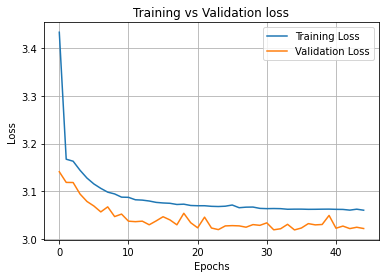

In [4]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

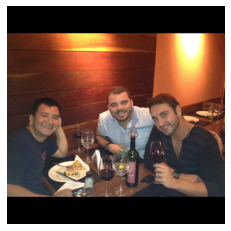

Predicted caption: a man is sitting at a table with a cake .
Original Captions:
0. A trio of men drinking wine at a restaurant table
1. three men sitting at  a table with some wine glasses
2. A group of three men at a restaurant drinking wine. 
3. A group of people that are sitting around a table.
4. Three men pose and smile at a table.


In [5]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [6]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 7min 50s, sys: 30.5 s, total: 8min 20s
Wall time: 2min 9s


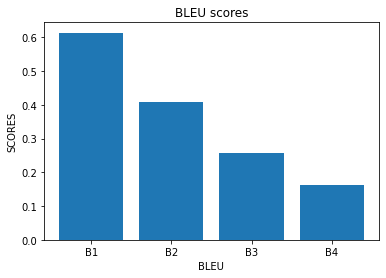

In [7]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [8]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 2: random_v2


In [9]:
CAPTIONS_NAME = 'random_v2'

captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_v2'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)


MODEL_SUMMARY = 'data samlped from entire MS Coco train2017 / val2017\n' \
                'train/val/test size 10k/2k/2k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")



model summary information:
------
data samlped from entire MS Coco train2017 / val2017
train/val/test size 10k/2k/2k
frequency threshold: 5
vocab size: 3389
batch size: 128
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 2000.


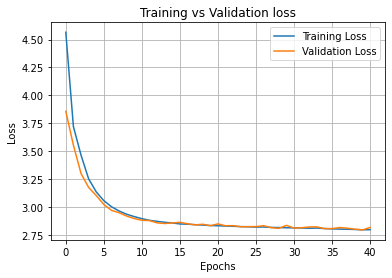

In [10]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

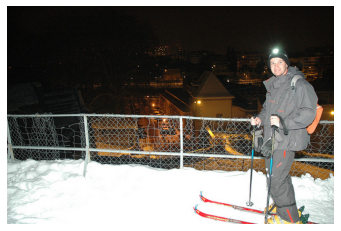

Predicted caption: a man is riding a skateboard on a snowy slope .
Original Captions:
0. A man riding skis on top of snow covered ground.
1. A man standing on his skiesat night with a light  on his head. a city is close behind him.
2. A man stands on his skis on a flat patch of snow near a fence.
3. A man is skiing on a bridge with snow. 
4. A man wears a light while skiing at night.


In [11]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [12]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 8min 54s, sys: 21.9 s, total: 9min 15s
Wall time: 1min 36s


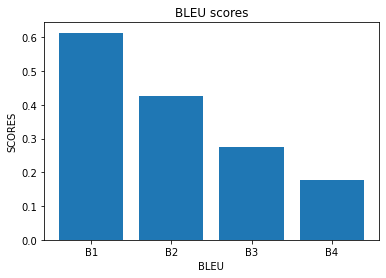

In [13]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [14]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 3 - sports_v1


In [73]:
CAPTIONS_NAME = 'sports_v1'

captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v1'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 10k/2k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")


model summary information:
------
only images containing objects from sports super-category.
train/val/test size 10k/2k/1k
frequency threshold: 5
vocab size: 2110
batch size: 128
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


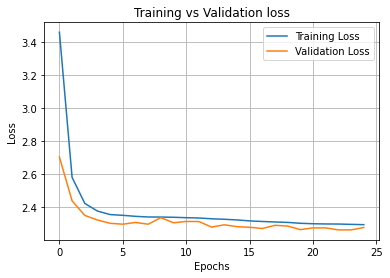

In [74]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

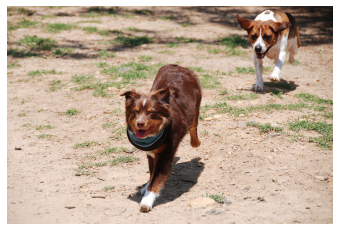

Predicted caption: a dog is holding a frisbee in the air .
Original Captions:
0. Two brown and white dogs running in a park. 
1. Two dogs, on wearing something heavy around its neck, run over the ground.
2. Two dogs running across patchy grass; one chasing the other.
3. two brown dogs walking in the field with their mouth open
4. Two dogs running and playing in the sun.


In [75]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [18]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 4min 16s, sys: 9.09 s, total: 4min 25s
Wall time: 40 s


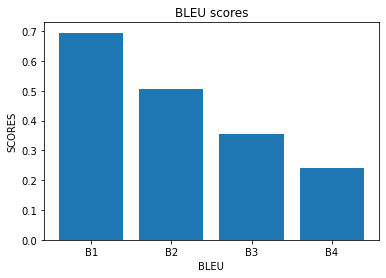

In [19]:
plot_bleu_score_bar(b1, b2, b3, b4)

### Analysis of word embeddings

In [79]:
print("Closest 5 embeddings to select words: sports_v1\n")
for word in ["snow", "hit", "runs", "sky", "woman"]:
    word_idx = word2idx[word]
    word_t = torch.IntTensor([word_idx]).to(device)
    word_emb = decoder.embed(word_t).cpu().detach().numpy()
    vocab_t = torch.IntTensor(list(range(len(idx2word)))).to(device)
    vocab_emb = decoder.embed(vocab_t).cpu().detach().numpy()

    k_emb = nearest_neighbor(word_emb, vocab_emb.tolist(), k=5)
    k_words = [idx2word[i] for i in k_emb]
    print("{:10}: {}".format(word, k_words))

Closest 5 embeddings to select words: sports_v1

snow      : ['water', 'speeds', 'surf', 'grass', 'graffiti']
hit       : ['serves', 'striking', 'hitting', 'hits', 'serving']
runs      : ['pulled', 'walking', 'running', 'walk', 'walks']
sky       : ['played', 'lake', 'together', 'daytime', 'slopes']
woman     : ['suits', 'child', 'kid', 'girl', 'man']


In [20]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 4 - sports_v2


In [80]:
CAPTIONS_NAME = 'sports_v2'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v3'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 4\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 4
vocab size: 2921
batch size: 128
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


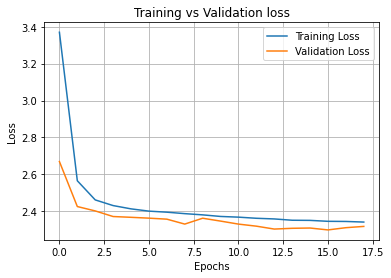

In [81]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

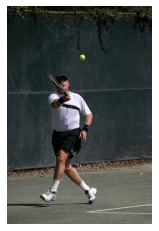

Predicted caption: a woman holding a tennis racket on a tennis court .
Original Captions:
0. A man swinging a tennis racquet towards a tennis ball.
1. A man holding a tennis racquet hits the ball.
2. A man running to hit a tennis ball with his racquet. 
3. A man running towards a ball with a tennis racket in his hand. 
4. a man reaching up with his tennis racket to hit the ball 
289


In [82]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")
print(idx[0])

#### Examples of sports_v2 doing well, average and poorly.

##### 1. Well

A man suring on a wave. Bang on!

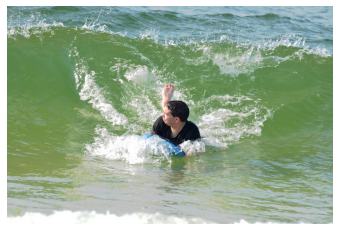

Predicted caption: a man riding a surfboard on a wave .
Original Captions:
0. A man riding a snowboard down a snow covered slope.
1. A person riding a snowboard down a snowy slope.
2. A man on skis is going down a slope.
3. A person on a snowy slope on a snowboard.
4. a couple skiers going down the snowy hill
425


In [6]:
img = test_dataset.get_img(91)
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")
print(idx[0])

##### 2. Average

The model often does this: "riding a skateboard on a skate board". Maybe the intuition is that the context can predict either something like "riding a rail on a skate board" or "riding a skateboard on a sunny day". The LSTM memory hasn't quite learned to forget the right thing: the probability of "skateboard" should be drastically reduced after its first use in the sentence.

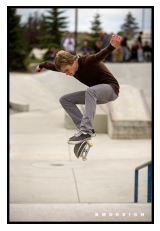

Predicted caption: a man riding a skateboard on a skate board .
Original Captions:
0. A man riding a snowboard down a snow covered slope.
1. A person riding a snowboard down a snowy slope.
2. A man on skis is going down a slope.
3. A person on a snowy slope on a snowboard.
4. a couple skiers going down the snowy hill
425


In [7]:
img = test_dataset.get_img(758)
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")
print(idx[0])

##### 2. Average

This is wrong, but you can understand how the model mistook a frisbee for a kite - it's flying in the air after all.

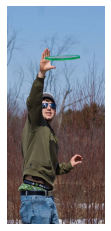

Predicted caption: a man holding a kite in a field .
Original Captions:
0. a person wearing a green hat playing nintendo wii
1. Man with a party hat happily playing on the Wii in his living room
2. A man in a living room playing video games.
3. An older man playing a video game with a green paper hat on his head.
4. A man playing a game with a wii controller in a living room.
703


In [12]:
img = test_dataset.get_img(455)
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")
print(idx[0])

##### 2. Poor

Totally wrong!

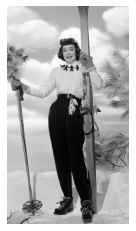

Predicted caption: a man holding a skateboard in a park .
Original Captions:
0. a person wearing a green hat playing nintendo wii
1. Man with a party hat happily playing on the Wii in his living room
2. A man in a living room playing video games.
3. An older man playing a video game with a green paper hat on his head.
4. A man playing a game with a wii controller in a living room.
703


In [13]:
img = test_dataset.get_img(658)
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")
print(idx[0])

In [14]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

KeyboardInterrupt: 

In [15]:
bleu_score = [b1, b2, b3, b4]
plot_bleu_score_bar(b1, b2, b3, b4)

NameError: name 'b1' is not defined

#### Can we make any observations about word embeddings?

In [83]:
import numpy as np
def cosine_similarity(vector_1: np.ndarray, vector_2: np.ndarray) -> float:
    """Calculates the similarity between two vectors

    Args:
     vector_1: array to compare
     vector_2: array to compare to vector_1

    Returns:
     cosine similarity between the two vectors
    """
    return np.dot(vector_1, vector_2)/(np.linalg.norm(vector_1) *
                                          np.linalg.norm(vector_2))

def nearest_neighbor(v, candidates, k=1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    return np.argsort(np.array([cosine_similarity(v, row) for row in candidates]).reshape(-1))[-k-1:-1]


In [84]:
print("Closest 5 embeddings to select words: sports_v2\n")
for word in ["snow", "hit", "runs", "sky", "woman"]:
    word_idx = word2idx[word]
    word_t = torch.IntTensor([word_idx]).to(device)
    word_emb = decoder.embed(word_t).cpu().detach().numpy()
    vocab_t = torch.IntTensor(list(range(len(idx2word)))).to(device)
    vocab_emb = decoder.embed(vocab_t).cpu().detach().numpy()

    k_emb = nearest_neighbor(word_emb, vocab_emb.tolist(), k=5)
    k_words = [idx2word[i] for i in k_emb]
    print("{:10}: {}".format(word, k_words))

Closest 5 embeddings to select words: sports_v2

snow      : ['wake', 'surf', 'water', 'graffiti', 'grass']
hit       : ['serve', 'hits', 'pitching', 'hitting', 'serving']
runs      : ['walk', 'waling', 'traveling', 'slide', 'barrels']
sky       : ['flown', 'boardwalk', 'boxes', 'skying', 'action']
woman     : ['coat', 'suit', 'jacket', 'man', 'girl']


In [26]:
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 5 - sports_v4

The entire train2017 captoins data set was used to build the vocabulary

In [27]:
CAPTIONS_NAME = 'sports_v4'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/2k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512\n' \
                'vocab build using entire train2017 captions data'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v4'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


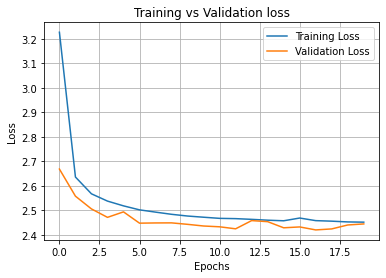

In [28]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

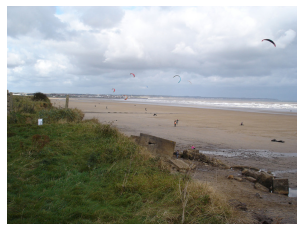

Predicted caption: a man is standing on a beach with a surfboard .
Original Captions:
0. A group of people flying kites on top of a sandy beach.
1. People are on the beach flying kites that look like arches in the sky.
2. people on a quiet beach playing with kites
3. Birds and Clouds roll over a sandy beach
4. People flying colorful kites on a deserted beach


In [29]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [30]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 58s, sys: 13.2 s, total: 4min 11s
Wall time: 53.7 s


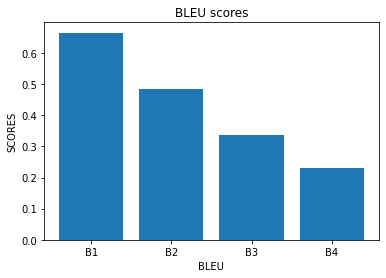

In [31]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [32]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 6 - sports_v5

All the sport data - 28k training size.

In [33]:
CAPTIONS_NAME = 'sports_v5'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v5'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 20k/3k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 20k/3k/1k
frequency threshold: 5
vocab size: 2988
batch size: 64
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


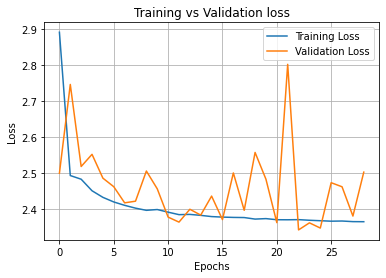

In [34]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

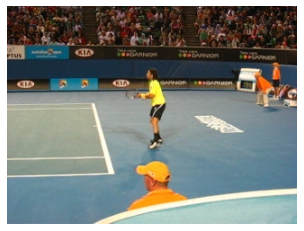

Predicted caption: a man on a skateboard in the air .
Original Captions:
0. a tennis player with a racket on a court 
1. Indoor tennis match, with a full crowd of spectators.
2. A man standing on a tennis court holding a racquet.
3. A tennis player in a crowded arena waits for the next volley.
4. a man playing tennis hits a ball across the court


In [35]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [36]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 2min 58s, sys: 11.6 s, total: 3min 10s
Wall time: 47.8 s


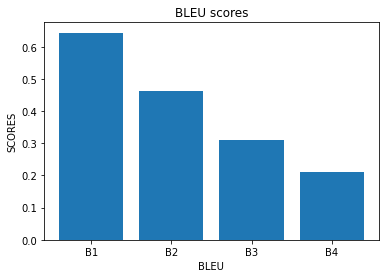

In [37]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [38]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 7 - everything


In [66]:
CAPTIONS_NAME = 'everything'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_everything'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'images sampled from entire train2017 data set\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
images sampled from entire train2017 data set
train/val/test size 102k/15k/5k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 4952.


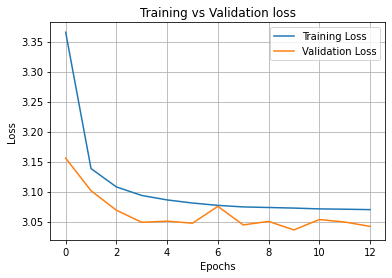

In [67]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

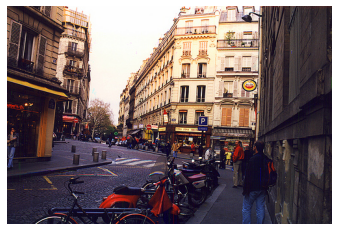

Predicted caption: a street with a bus on the street .
Original Captions:
0. A row of parked motorcycles sitting in front of a tall building.
1. A stone street with bicycles and motor bikes parked on the side and people standing on the sidewalks in front of buildings.
2.  Cityscape of pedestrians enjoying an old European city
3. a row of bikes and mopeds is parked along the street
4. Motorcycles and mopeds line a side street during the day in a city.


In [68]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [42]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 17min 19s, sys: 43.4 s, total: 18min 3s
Wall time: 3min 3s


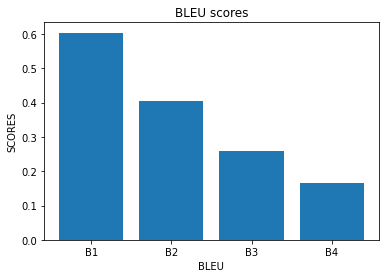

In [43]:
plot_bleu_score_bar(b1, b2, b3, b4)

#### Analysis of word embeddings

In [71]:
print("Closest 5 embeddings to select words: everything\n")
for word in ["snow", "hit", "runs", "sky", "woman"]:
    word_idx = word2idx[word]
    word_t = torch.IntTensor([word_idx]).to(device)
    word_emb = decoder.embed(word_t).cpu().detach().numpy()
    vocab_t = torch.IntTensor(list(range(len(idx2word)))).to(device)
    vocab_emb = decoder.embed(vocab_t).cpu().detach().numpy()

    k_emb = nearest_neighbor(word_emb, vocab_emb.tolist(), k=5)
    k_words = [idx2word[i] for i in k_emb]
    print("{:10}: {}".format(word, k_words))

Closest 5 embeddings to select words: everything

snow      : ['gliding', 'galloping', 'soaring', 'grass', 'rain']
hit       : ['grinds', 'checks', 'throw', 'presents', 'from']
runs      : ['skateboards', 'skateboard', 'penned', 'crashes', 'running']
sky       : ['ground', 'land', 'house', 'road', 'river']
woman     : ['person', 'girl', 'sweatshirt', 'man', 'boy']


In [44]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 8 - random_v3


In [45]:
CAPTIONS_NAME = 'random_v3'

captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_v3'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)


MODEL_SUMMARY = 'data samlped from entire MS Coco train2017 / val2017\n' \
                'train/val/test size 10k/2k/2k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")



model summary information:
------
data samlped from entire MS Coco train2017 / val2017
train/val/test size 10k/2k/2k
frequency threshold: 5
vocab size: 4699
batch size: 128
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 2000.


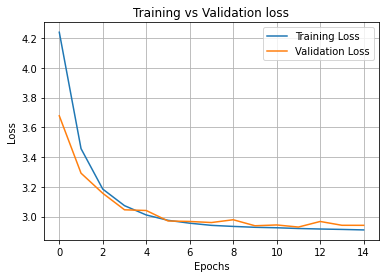

In [46]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

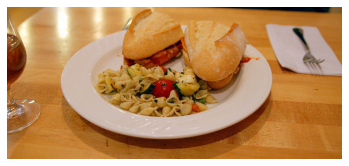

Predicted caption: a plate with a plate of food and a bowl of food .
Original Captions:
0. A sandwich on a plate cutin half next to pasta.
1. A dinner plate containing a sandwich and pasta.
2. A sandwich cut in half is on a plate with macaroni.
3. Sandwich and pasta salad with a drink for one
4. a sandwich on a plate on a desk near a glass of wine


In [47]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [48]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 7min 37s, sys: 15.6 s, total: 7min 53s
Wall time: 1min 8s


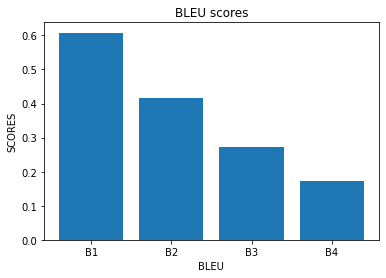

In [49]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [50]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, param["embed_size"],
             param["hidden_size"], param["num_layers"], param["vocab_size"], param["batch_size"],
             training_loss, validation_loss, bleu_score)

## Model 9 - sports "v2" but with modified encoder.

Our encoder has two fully connected layers at the end. We ran this model to compare with a more traditional architecture where you remove the last fc resnet layer and replace with just one layer. 

The training speed and final results are almost identical.

In [ ]:
CAPTIONS_NAME = 'sports_encoder'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_encoder'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

In [ ]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

In [ ]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [ ]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

In [ ]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [ ]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)